In [1]:
import sys
sys.path.append('./rllab')
sys.path.append('./rltools')

# from __future__ import print_function
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

from madrl_environments.cas.multi_aircraft import *
from matplotlib import rcParams
import matplotlib.pyplot as plt

import joblib
import tensorflow as tf
import numpy as np

In [2]:
import math

In [3]:
XMIN = -1200
XMAX = 1200
YMIN = XMIN
YMAX = XMAX

In [4]:
def vis_slice(env,
              policy,
              clip=False,
              figsize=4,
              colorbar_label=True,
              ylabel=True,
              save=False,
              resolution=100,
              own_v=20, 
              own_heading=0,
              own_turn_rate=0,
              own_dest_x=4000,
              own_dest_y=0,
              int_heading=180, 
              int_v=15):
    
    rcParams["figure.figsize"] = [figsize, figsize]
    # ownship setup
    env.aircraft[0].x = 0
    env.aircraft[0].y = 0
    env.aircraft[0].dest_x = own_dest_x
    env.aircraft[0].dest_y = own_dest_y
    env.aircraft[0].heading = np.deg2rad(own_heading)
    env.aircraft[0].dist_to_dest = np.sqrt((env.aircraft[0].dest_y)**2 + (env.aircraft[0].dest_x)**2)
    env.aircraft[0].init_dist_to_dest = env.aircraft[0].dist_to_dest * 2
    env.aircraft[0].prev_dist_to_dest = env.aircraft[0].dist_to_dest + own_v
    env.aircraft[0].v = own_v
    env.aircraft[0].turn_rate = own_turn_rate
    
    def get_heat(x, y):
        # intruder setup
        env.aircraft[1].x = x
        env.aircraft[1].y = y
        intruder_pos_angle = math.atan2(y - env.aircraft[0].y, x - env.aircraft[0].x)
        env.aircraft[1].heading = np.deg2rad(int_heading)
        env.aircraft[1].v = int_v
        # ownship:
        obs = env.aircraft[0].get_observation()
        action, action_info = policy.get_action(obs)
        return action, action_info

    acc_map = np.zeros((resolution, resolution))
    turn_rate_map = np.zeros((resolution, resolution))
    x_arr = np.linspace(XMIN, XMAX, resolution)
    y_arr = np.linspace(YMIN, YMAX, resolution)


    for j in range(resolution):
        for i in range(resolution):
            actions = get_heat(x_arr[i], y_arr[j])[1]['mean']
            if clip:
                acc_map[j][i] = np.clip(actions[ACTION_IND_ACC], -1, 1) * MAX_ACC
                turn_rate_map[j][i] = np.clip(actions[ACTION_IND_TURN], -1, 1) * np.rad2deg(MAX_TURN_RATE)
            else:
                acc_map[j][i] = actions[ACTION_IND_ACC] * MAX_ACC
                turn_rate_map[j][i] = actions[ACTION_IND_TURN] * np.rad2deg(MAX_TURN_RATE)

    acc_map = np.flipud(acc_map)
    turn_rate_map = np.flipud(turn_rate_map)

    plt.figure()
    if clip:
        plt.title('Clipped Acceleration')
    else:
        plt.title('Non-clipped Acceleration')
    plt.xlabel('x (m)')
    if ylabel:
        plt.ylabel('y (m)')
    else:
        plt.gca().axes.get_yaxis().set_ticks([])
    plt.xlim(XMIN, XMAX) 
    plt.ylim(YMIN, YMAX) 
    plt.imshow(acc_map, cmap="jet", extent=(XMIN, XMAX, YMIN, YMAX))
    if colorbar_label:
        plt.colorbar(label='Acceleration (m/sec^2)')
    else:
        plt.colorbar()
    plt.plot([0, own_dest_x], [0, own_dest_y], color='white', linestyle="--")
    plt.arrow(0, 0,
              np.cos(np.deg2rad(own_heading)),
              np.sin(np.deg2rad(own_heading)),
              width=60,
              facecolor="green")
    plt.arrow(0.76 * XMAX, 0.76 * YMAX,
              np.cos(np.deg2rad(int_heading)),
              np.sin(np.deg2rad(int_heading)),
              width=60,
              facecolor="white")
    if save:
        if clip:
            plt.savefig('clipped_action_map_acc.pdf', bbox_inches='tight', pad_inches=0)
        else:
            plt.savefig('non_clipped_action_map_acc.pdf', bbox_inches='tight', pad_inches=0)
    
    plt.figure()
    if clip:
        plt.title('Clipped Turn Rate')
    else:
        plt.title('Non-clipped Turn Rate')
    plt.xlabel('x (m)')
    if ylabel:
        plt.ylabel('y (m)')
    else:
        plt.gca().axes.get_yaxis().set_ticks([])
    plt.xlim(XMIN, XMAX) 
    plt.ylim(YMIN, YMAX) 
    plt.imshow(turn_rate_map, cmap="jet", extent=(XMIN, XMAX, YMIN, YMAX))
    if colorbar_label:
        plt.colorbar(label='Turn Rate (deg/sec)')
    else:
        plt.colorbar()
    plt.plot([0, own_dest_x], [0, own_dest_y], color='white', linestyle="--")
    plt.arrow(0, 0,
              np.cos(np.deg2rad(own_heading)),
              np.sin(np.deg2rad(own_heading)),
              width=60,
              facecolor="green")
    plt.arrow(0.76 * XMAX, 0.76 * YMAX,
              np.cos(np.deg2rad(int_heading)),
              np.sin(np.deg2rad(int_heading)),
              width=60,
              facecolor="white")
    plt.ion()
    if save:
        if clip:
            plt.savefig('clipped_action_map_turnrate.pdf', bbox_inches='tight', pad_inches=0)
        else:
            plt.savefig('non_clipped_action_map_turnrate.pdf', bbox_inches='tight', pad_inches=0)


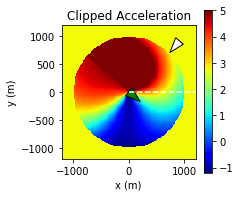

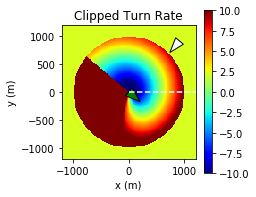

In [5]:
data_file_path = './rllab/data/trpo_20_agent_direct_ALL_ENV_Tmax_300_PEN_HEAVY_True_rew_nmac_-150_rew_arr_2/itr_2064_direct_real_good.pkl'
tf.reset_default_graph()
with tf.Session() as sess:
    data = joblib.load(data_file_path)
    policy = data['policy']
    
    env = MultiAircraftEnv()
    env.reset()
    env.aircraft = []
    env.aircraft.append(Aircraft(env))
    env.aircraft.append(Aircraft(env))
    
    vis_slice(env, policy, 
              clip=True,
              resolution=150,
              own_v=30, 
              own_heading=-40,
              own_turn_rate=0,
              own_dest_x=2000,
              own_dest_y=0,
              int_heading=-130, 
              int_v=30,
              colorbar_label=False,
              ylabel=True,
              figsize=3,
              save=True)
    
